## Дата Сет CIFAR10

In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.datasets
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [5]:
len(y_train), len(y_test)

(50000, 10000)

In [0]:
X_train /= 255. #Чтобы пиксель лежат в диапазоне от 0 до 1
X_test /= 255.

In [7]:
print(CIFAR_train.classes) #Тренировочные классы
X_train.shape, y_train.shape #[кол-во, ширина, высота, кол-во каналов]

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
torch.cuda.is_available()
!nvidia-smi

Tue Apr  7 19:29:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    33W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Визуализация

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

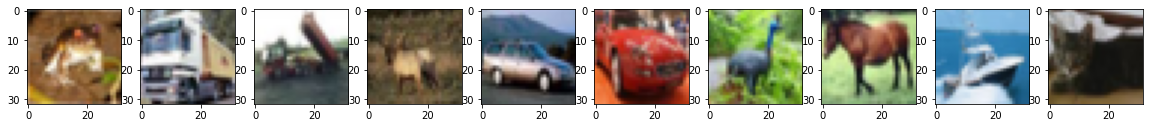

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [10]:
X_train = X_train.permute(0, 3, 1, 2) #Ставим на 2 место кол-во каналов
X_test = X_test.permute(0, 3, 1, 2)
X_train.shape 

torch.Size([50000, 3, 32, 32])

In [0]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [0]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)

    del net
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}

In [13]:
accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),X_train, y_train, X_test, y_test)
accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)
accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)

tensor(0.3876)
tensor(0.4334)
tensor(0.4709)
tensor(0.4962)
tensor(0.4969)
tensor(0.5182)
tensor(0.5263)
tensor(0.5363)
tensor(0.5425)
tensor(0.5401)
tensor(0.5461)
tensor(0.5455)
tensor(0.5432)
tensor(0.5542)
tensor(0.5565)
tensor(0.5588)
tensor(0.5550)
tensor(0.5537)
tensor(0.5534)
tensor(0.5523)


KeyboardInterrupt: ignored

## Графики для accuracy

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Validation Accuracy')

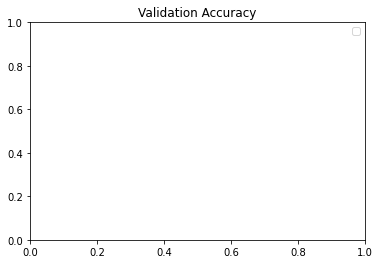

In [0]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy')

## Графики для loss

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Validation Loss')

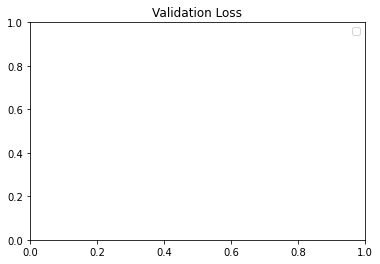

In [0]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss')

In [0]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        #Батч-нормализация к исходному изображению
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        #Первая Свертка 3x3, из 3 каналов в 16 каналов
        #padding = 1 - изображение в старом размере
        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU() #Функция активации
        self.batch_norm1 = torch.nn.BatchNorm2d(16) #Батч-нормализация
        self.pool1 = torch.nn.MaxPool2d(2, 2) #МаксПулинг
        
        #Вторая Свертка 3x3, из 16 каналов в 32 каналов
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        #Третья Свертка 3x3, из 32 каналов в 64 каналов
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        #Первый полносвязный слой
        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh() #Активация
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        #Второй полносвязный слой
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        #Третий полносвязный слой
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)

        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3)) #Разворачиваем вектор
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        
        return x

### Результаты

In [13]:
accuracies['cifar_net'], losses['cifar_net'] = \
    train(CIFARNet(), X_train, y_train, X_test, y_test)

tensor(0.6600)
tensor(0.7035)
tensor(0.7146)
tensor(0.7217)
tensor(0.7159)
tensor(0.7201)
tensor(0.7251)
tensor(0.7266)
tensor(0.7144)
tensor(0.7224)
tensor(0.7168)
tensor(0.7170)
tensor(0.7142)
tensor(0.7170)
tensor(0.7119)
tensor(0.7208)
tensor(0.7172)
tensor(0.7137)
tensor(0.7192)
tensor(0.7175)
tensor(0.7117)
tensor(0.7224)
tensor(0.7214)
tensor(0.7209)
tensor(0.7238)
tensor(0.7225)
tensor(0.7250)
tensor(0.7185)
tensor(0.7270)
tensor(0.7218)


Text(0.5, 1.0, 'Validation Accuracy')

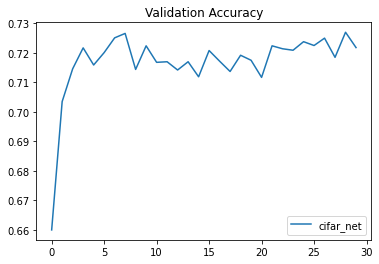

In [14]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy')

Text(0.5, 1.0, 'Validation Loss')

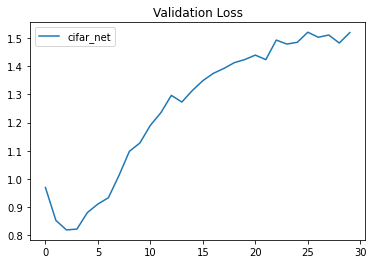

In [15]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss')

### Сеть ResNet18

In [0]:
from torchvision.models import resnet18

In [15]:
accuracies['resnet18'], losses['resnet18'] = \
    train(resnet18(), X_train, y_train, X_test, y_test)

tensor(0.5420)
tensor(0.6096)
tensor(0.6196)
tensor(0.6729)
tensor(0.6663)
tensor(0.6983)
tensor(0.7343)
tensor(0.7163)
tensor(0.7166)
tensor(0.7410)
tensor(0.7403)
tensor(0.7463)
tensor(0.7429)
tensor(0.7429)
tensor(0.7384)
tensor(0.7391)
tensor(0.7532)
tensor(0.7518)
tensor(0.6981)
tensor(0.7463)
tensor(0.7471)
tensor(0.7384)
tensor(0.7502)
tensor(0.7353)
tensor(0.7590)
tensor(0.7599)
tensor(0.7531)


KeyboardInterrupt: ignored

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Validation Accuracy')

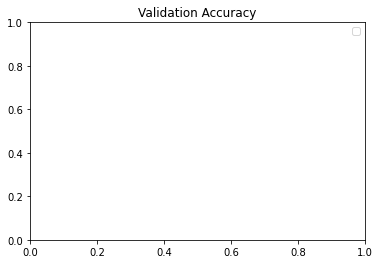

In [17]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy')